In [1]:
#Import Libraries
import pandas as pd
import numpy as np
%matplotlib inline
from keras.layers import LSTM
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from keras.models import Sequential
import tensorflow as tf
from keras.layers import Dense
import keras.backend as K
from keras.optimizers import Adam
from keras.layers import Dropout
import tensorflow as tf
from keras.preprocessing.sequence import TimeseriesGenerator
from pandas.tseries.offsets import BusinessDay

In [2]:
#open data source
df = pd.read_csv('Forex_20_years.csv')
#clean/prep data
df = df[['Date', 'EUR']]
df.Date = pd.to_datetime(df.Date)
df = df.set_index("Date")
df.head()

,EUR
Date,
2003-01-02,0.9652
2003-01-03,0.9599
2003-01-06,0.9552
2003-01-07,0.9598
2003-01-08,0.9572


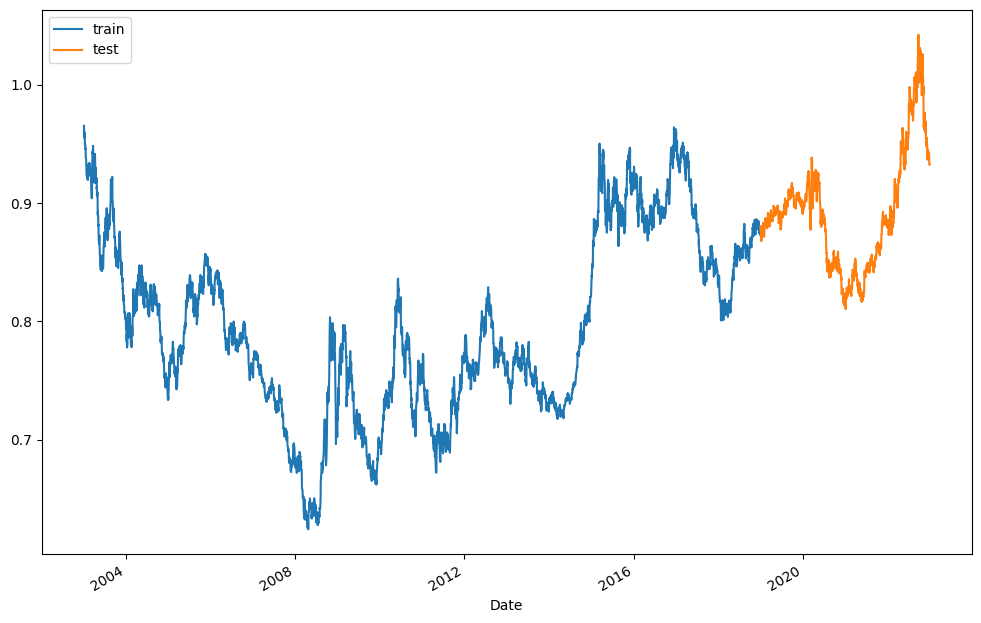

In [3]:
#split into test and train
split_date = pd.Timestamp('2019-01-01')

train = df.loc[:split_date]
test = df.loc[split_date:]

#visualize the split
ax = train.plot(kind='line',figsize=(12,8))
test.plot(ax=ax,kind='line',figsize=(12,8))
plt.legend(['train', 'test'])

In [4]:
#data normalization with standard scaler
sc = StandardScaler()
train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

X_train = train_sc[:-1]
y_train = train_sc[1:]

X_test = test_sc[:-1]
y_test = test_sc[1:]

In [5]:
#data normalization with standard scaler
sc = StandardScaler()
train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

X_train = train_sc[:-1]
y_train = train_sc[1:]

X_test = test_sc[:-1]
y_test = test_sc[1:]

In [6]:
#Set up the lstm model
K.clear_session()
test_lstm = Sequential()
test_lstm.add(LSTM(50, input_shape=(1, X_train.shape[1]), activation='relu', kernel_initializer='lecun_uniform', return_sequences=False))
test_lstm.add(Dense(1))
test_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [7]:
#compile the test set model
test_lstm.compile(loss=tf.keras.metrics.mean_squared_error,
              metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')], optimizer='adam')
#fit the test set model
history = test_lstm.fit(X_train, y_train, epochs=100, batch_size=1, verbose=1, shuffle=False)

Epoch 1/100
4016/4016 [==============================] - 11s 2ms/step - loss: 0.0495 - rmse: 0.2224
Epoch 2/100
4016/4016 [==============================] - 10s 2ms/step - loss: 0.0057 - rmse: 0.0756
Epoch 3/100
4016/4016 [==============================] - 9s 2ms/step - loss: 0.0057 - rmse: 0.0757
Epoch 4/100
4016/4016 [==============================] - 9s 2ms/step - loss: 0.0056 - rmse: 0.0746
Epoch 5/100
4016/4016 [==============================] - 10s 2ms/step - loss: 0.0054 - rmse: 0.0734
Epoch 6/100
4016/4016 [==============================] - 10s 2ms/step - loss: 0.0053 - rmse: 0.0726
Epoch 7/100
4016/4016 [==============================] - 9s 2ms/step - loss: 0.0052 - rmse: 0.0721
Epoch 8/100
4016/4016 [==============================] - 10s 2ms/step - loss: 0.0051 - rmse: 0.0717
Epoch 9/100
4016/4016 [==============================] - 10s 2ms/step - loss: 0.0051 - rmse: 0.0714
Epoch 10/100
4016/4016 [==============================] - 9s 2ms/step - loss: 0.0051 - rmse: 0.0712
Epo

In [8]:
#print prediction stats on the test set model
y_pred_test_lstm = test_lstm.predict(X_test)
y_train_pred_lstm = test_lstm.predict(X_train)

train_mse = metrics.mean_squared_error(y_train, y_train_pred_lstm)
rmse_train = np.sqrt(train_mse)

test_mse = metrics.mean_squared_error(y_test, y_pred_test_lstm)
rmse_test = np.sqrt(test_mse)

print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_lstm)))
print("The  MAE on the Train set is:\t{:0.3f}".format(metrics.mean_absolute_error(y_train, y_train_pred_lstm)))
print("The  RMSE on the Train set is:\t{:0.3f}".format(rmse_train))
r2_train = r2_score(y_train, y_train_pred_lstm)
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_lstm)))
r2_test = r2_score(y_test, y_pred_test_lstm)
print("The  MAE on the Test set is:\t{:0.3f}".format(metrics.mean_absolute_error(y_test, y_pred_test_lstm)))
print("The  RMSE on the Test set is:\t{:0.3f}".format(rmse_test))

126/126 [==============================] - 0s 2ms/step
The R2 score on the Train set is:	0.982
The  MAE on the Train set is:	0.105
The  RMSE on the Train set is:	0.136
The R2 score on the Test set is:	0.937
The  MAE on the Test set is:	0.107
The  RMSE on the Test set is:	0.168


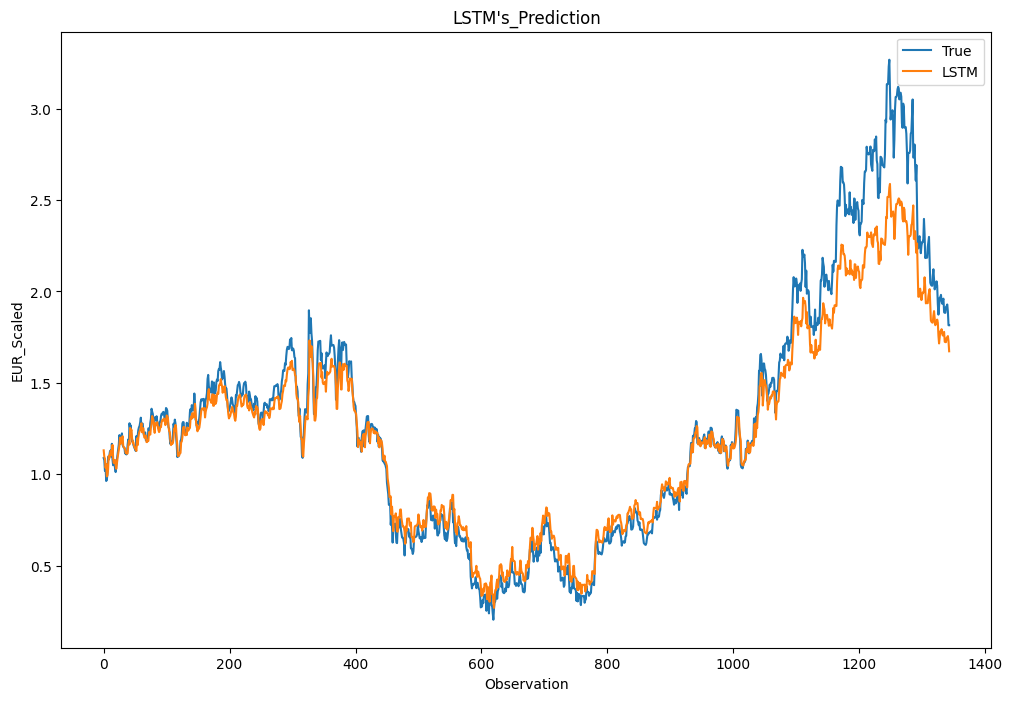

In [9]:
#Visualize performance against test data
#data still scaled at this point
plt.figure(figsize=(12,8))
plt.plot(y_test, label='True')
plt.plot(y_pred_test_lstm, label='LSTM')
plt.title("LSTM's_Prediction")
plt.xlabel('Observation')
plt.ylabel('EUR_Scaled')
plt.legend()
plt.show()

In [10]:
##return the data to original scale
inv_pred = sc.inverse_transform(y_pred_test_lstm)
inv_ytest = sc.inverse_transform(y_test)

In [11]:
#set up a data frame for comparison
col1 = pd.DataFrame(inv_ytest, columns=['EUR'])

col2 = pd.DataFrame(inv_pred, columns=['LSTM_prediction'])

results = pd.concat([col1, col2], axis=1)
results.head()

,EUR,LSTM_prediction
0,0.8773,0.880483
1,0.8764,0.877789
2,0.8720,0.877029
3,0.8738,0.873293
4,0.8678,0.874825


In [14]:
#reset the index on test df for future merge
test.reset_index(level=0, inplace=True)
#merge to get data set with dates, true and prediction for each
df_final = test.merge(results, how='inner', left_on='EUR', right_on='EUR')
#drop duplicates
df_final.drop_duplicates(subset='Date', inplace=True)
#sort by date ascending
df_final.sort_values(by='Date', ascending = True, inplace = True)
#set the date as the index once more
df_final = df_final.set_index("Date")
#check df
df_final.head()

,index,EUR,LSTM_prediction
Date,,,
2019-01-02,0,0.8805,0.878970
2019-01-03,1,0.8773,0.880483
2019-01-04,2,0.8764,0.877789
2019-01-07,3,0.8720,0.877029
2019-01-08,4,0.8738,0.873293


In [15]:
#create csv for validation results
df_final.to_csv('EUR_final_test.csv')

In [16]:
#TRANSITION TO FORECASTING USING SAME MODEL SETUP

In [17]:
#set the entire 20 years as "train" data
train = df
#scale the data
scaler = StandardScaler()
scaler.fit(train)
train = scaler.transform(train)

In [18]:
#setting up the forecast model

#number of time steps to predict: 15 business days or three weeks worth of business days
n_input = 15
#set number of features: univariate, one feature
n_features = 1
#Set up the time series generator
generator = TimeseriesGenerator(train, train, length=n_input, batch_size=1, shuffle=False)
#set up the forecast model, same parameters as before that performed well on validation set
forecast_lstm = Sequential()
forecast_lstm.add(LSTM(50, input_shape=(n_input, n_features), activation='relu', kernel_initializer='lecun_uniform', return_sequences=False))
forecast_lstm.add(Dense(1))
forecast_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 50)                10400     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [19]:
#compile the forecast model
forecast_lstm.compile(loss=tf.keras.metrics.mean_squared_error,
              metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')], optimizer='adam')
#fit the forecast model using the generator
forecast_lstm.fit(generator,epochs=100)
#set up a prediction list for the forecasted data points
pred_list = []  
batch = train[-n_input:].reshape((1, n_input, n_features))
for i in range(n_input):
    pred_list.append(forecast_lstm.predict(batch)[0])      
    batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)

Epoch 1/100
5347/5347 [==============================] - 46s 8ms/step - loss: 0.0465 - rmse: 0.2156
Epoch 2/100
5347/5347 [==============================] - 43s 8ms/step - loss: 0.0051 - rmse: 0.0711
Epoch 3/100
5347/5347 [==============================] - 43s 8ms/step - loss: 0.0043 - rmse: 0.0654
Epoch 4/100
5347/5347 [==============================] - 41s 8ms/step - loss: 0.0039 - rmse: 0.0627
Epoch 5/100
5347/5347 [==============================] - 43s 8ms/step - loss: 0.0037 - rmse: 0.0612
Epoch 6/100
5347/5347 [==============================] - 42s 8ms/step - loss: 0.0037 - rmse: 0.0610
Epoch 7/100
5347/5347 [==============================] - 41s 8ms/step - loss: 0.0036 - rmse: 0.0604
Epoch 8/100
5347/5347 [==============================] - 42s 8ms/step - loss: 0.0036 - rmse: 0.0604
Epoch 9/100
5347/5347 [==============================] - 42s 8ms/step - loss: 0.0037 - rmse: 0.0605
Epoch 10/100
5347/5347 [==============================] - 42s 8ms/step - loss: 0.0036 - rmse: 0.0601

In [20]:
#create dates for the desired future business days
future_bd = pd.bdate_range('2023-01-01', '2023-01-21')
#create data frame for those dates
col1 = pd.DataFrame(future_bd, columns=['Date'])
#reverse scale the prediction list
scaled_pred = scaler.inverse_transform(pred_list)
#create data frame for those scaled predictions
col2 = pd.DataFrame(scaled_pred, columns=['Prediction'])
#create a data frame with col1 and col2 for the future dates and their predictions
df_predict = pd.concat([col1, col2], axis=1)
#set date as index
df_predict = df_predict.set_index("Date")
df_predict

,Prediction
Date,
2023-01-02,0.931537
2023-01-03,0.930549
2023-01-04,0.929563
2023-01-05,0.928836
2023-01-06,0.928108
2023-01-09,0.927490
2023-01-10,0.926885
2023-01-11,0.926299
2023-01-12,0.925701


In [21]:
#create a data frame that adds forecast data points to the end of the original data frame
df_proj = pd.concat([df,df_predict], axis=1)
#check that all dates present
df_proj.head()

,EUR,Prediction
Date,,
2003-01-02,0.9652,NaN
2003-01-03,0.9599,NaN
2003-01-06,0.9552,NaN
2003-01-07,0.9598,NaN
2003-01-08,0.9572,NaN


In [22]:
#end dates check
df_proj.tail(17)

,EUR,Prediction
Date,,
2022-12-30,0.93225,NaN
2022-12-31,0.93225,NaN
2023-01-02,NaN,0.931537
2023-01-03,NaN,0.930549
2023-01-04,NaN,0.929563
2023-01-05,NaN,0.928836
2023-01-06,NaN,0.928108
2023-01-09,NaN,0.927490
2023-01-10,NaN,0.926885


In [23]:
#save both data frames as csv's
df_predict.to_csv('EUR_15_predictions.csv')
df_proj.to_csv('EUR_full_data.csv')